# MFCC Feature Extraction and Comparative Analysis of Indian Languages

**Abstract**
This task explores the application of Mel-Frequency
Cepstral Coefficients (MFCC) in analyzing and classifying Indian
languages using machine learning. We begin by extracting MFCC
features from an audio dataset containing ten Indian languages.
A comparative analysis of MFCC spectrograms is performed
to identify unique spectral patterns and statistical differences
across languages. In the second phase, these extracted MFCC
features are used to train a neural network classifier to predict the
language of a given audio sample. The classifier achieves an accuracy of 85.89%, demonstrating the effectiveness of MFCC-based
language identification. However, a notable misclassification trend
is observed between Gujarati and Punjabi, with Gujarati often
being incorrectly predicted as Punjabi. This highlights phonetic
and spectral similarities between these languages. Additionally,
we analyze performance metrics such as confusion matrices
and classification reports to evaluate the model’s strengths and
weaknesses. The findings highlight key acoustic variations among
Indian languages and the potential of deep learning for language
classification tasks

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
hbchaitanyabharadwaj_audio_dataset_with_10_indian_languages_path = kagglehub.dataset_download('hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages')

print('Data source import complete.')


# Import Libraries

In [ ]:
import os
import torch
import random
import torchaudio
import torchaudio.transforms as transforms
import librosa.display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import display, Audio

# Dataset Setup

In [ ]:
DATASET_PATH = "/kaggle/input/Language Detection Dataset"
languages = [ "Bengali","Gujarati","Hindi","Kannada","Malayalam","Marathi","Punjabi","Tamil", "Telugu", "Urdu",]

# Audio Processing Functions

In [ ]:
def load_audio(file_path):
    try:
        waveform, sample_rate = torchaudio.load(file_path)

        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        return waveform, sample_rate
    except Exception as e:
        print(f"Skipping {file_path} due to error: {e}")
        return None, None

# MFCC Feature Extraction and Visualization

In [ ]:
def extract_mfcc(waveform, sample_rate, n_mfcc=13):
    mfcc_transform = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=n_mfcc,
        melkwargs={"n_mels": 40, "n_fft": 1024}
    )
    mfcc = mfcc_transform(waveform)
    return mfcc.squeeze().numpy()

In [ ]:
def plot_mfcc(mfcc, title):
    plt.figure(figsize=(10, 4))
    sns.heatmap(mfcc, cmap="viridis", xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xlabel("Time Frames")
    plt.ylabel("MFCC Coefficients")
    plt.show()

In [ ]:
print(os.listdir("/kaggle/input"))


['Language Detection Dataset']


MFCC Visualization for BENGALI:


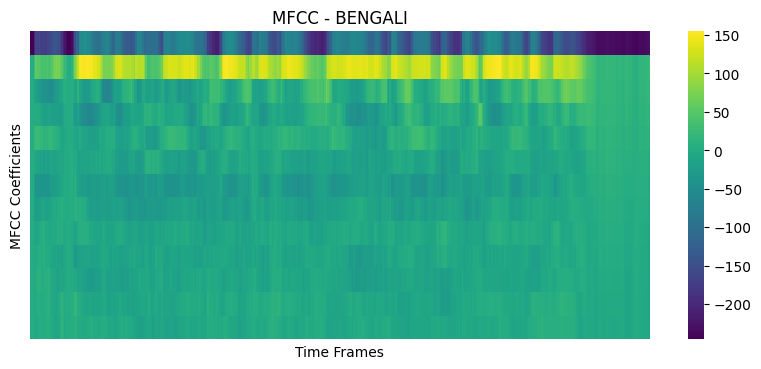


MFCC Visualization for GUJARATI:


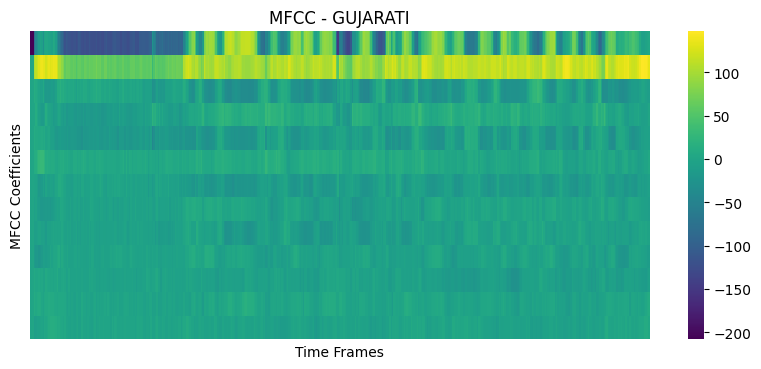


MFCC Visualization for HINDI:


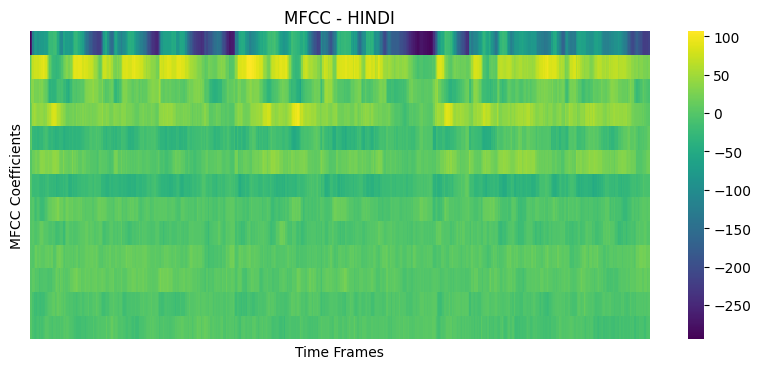


MFCC Visualization for KANNADA:


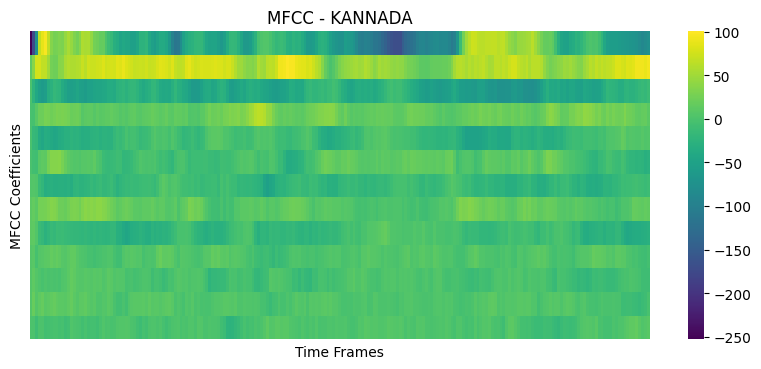


MFCC Visualization for MALAYALAM:


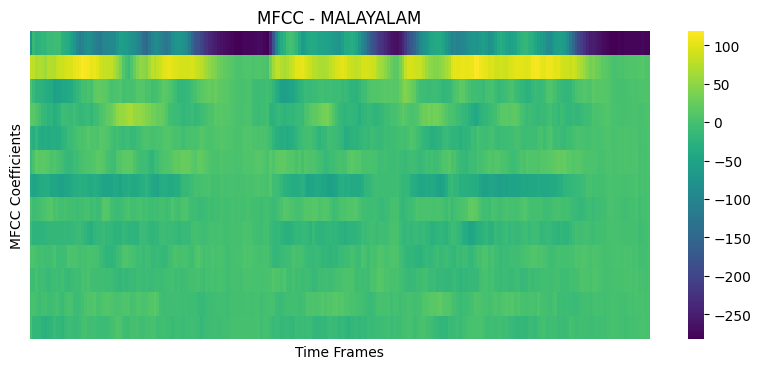


MFCC Visualization for MARATHI:


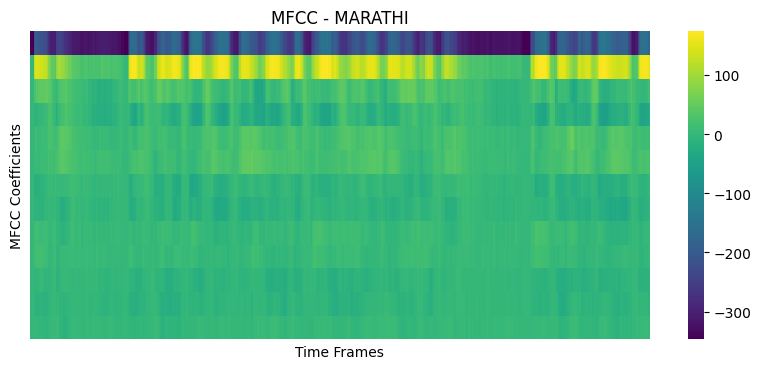


MFCC Visualization for PUNJABI:


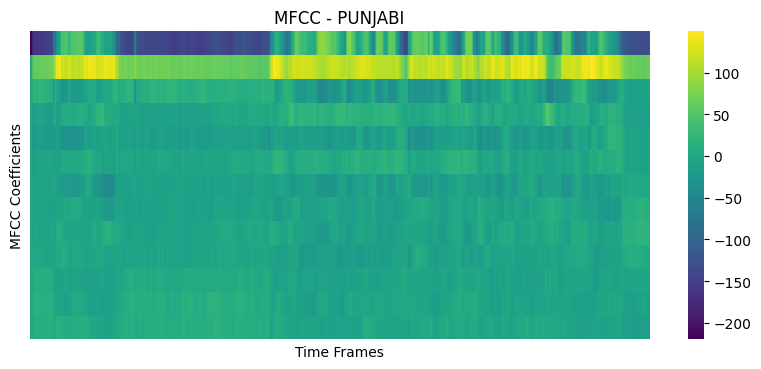


MFCC Visualization for TAMIL:


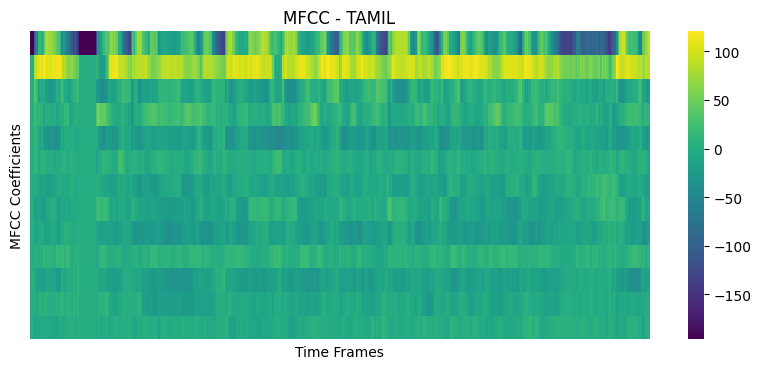


MFCC Visualization for TELUGU:


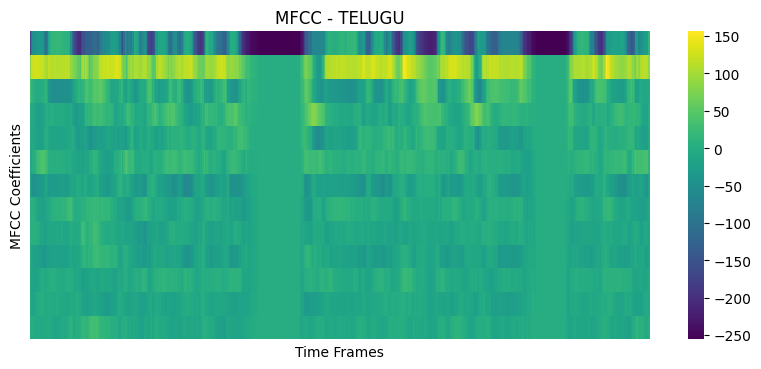


MFCC Visualization for URDU:


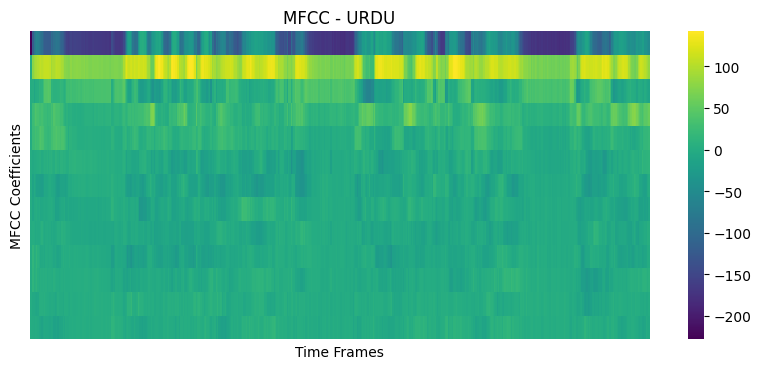

In [ ]:
for lang in languages:
    lang_path = os.path.join(DATASET_PATH, lang)
    audio_files = [f for f in os.listdir(lang_path) if f.endswith(".mp3")]

    if not audio_files:
        print(f"No MP3 files found for {lang}")
        continue

    sample_file = os.path.join(lang_path, audio_files[0])
    waveform, sample_rate = load_audio(sample_file)
    mfcc = extract_mfcc(waveform, sample_rate)

    print(f"MFCC Visualization for {lang.upper()}:")
    plot_mfcc(mfcc, f"MFCC - {lang.upper()}")
    print()


# Statistical Analysis of MFCC Features

In [ ]:
mfcc_statistics = {}

for lang in languages:
    lang_path = os.path.join(DATASET_PATH, lang)
    audio_files = [f for f in os.listdir(lang_path) if f.endswith(".mp3")]

    mfcc_values = []
    for file in audio_files[:100]:
        file_path = os.path.join(lang_path, file)
        waveform, sample_rate = load_audio(file_path)
        mfcc = extract_mfcc(waveform, sample_rate)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_values.append(mfcc_mean)

    if mfcc_values:
        mfcc_values = np.array(mfcc_values)
        mfcc_statistics[lang] = {
            "Mean": mfcc_values.mean(axis=0),
            "Variance": mfcc_values.var(axis=0)
        }


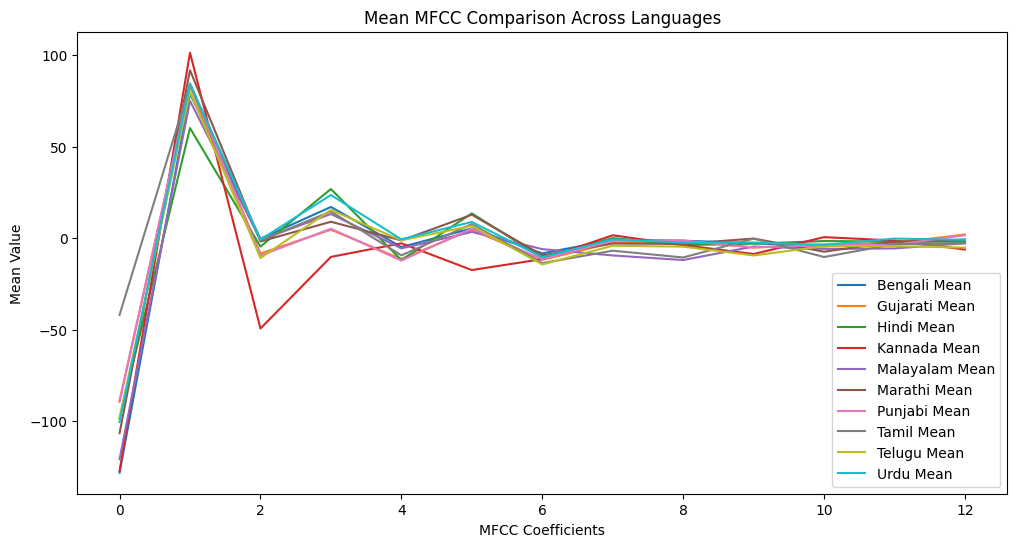

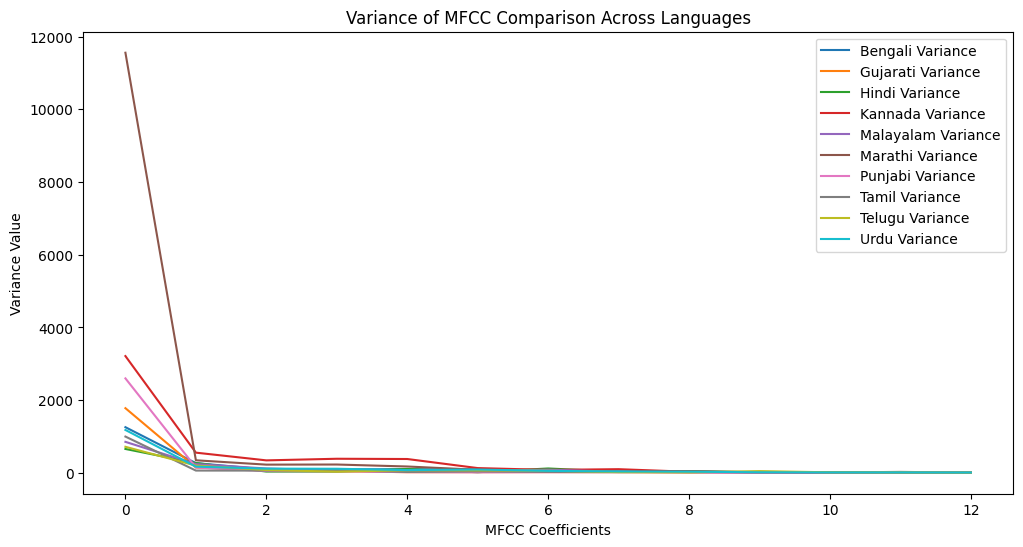

In [ ]:
plt.figure(figsize=(12, 6))
for lang, stats in mfcc_statistics.items():
    plt.plot(stats["Mean"], label=f"{lang} Mean")
plt.title("Mean MFCC Comparison Across Languages")
plt.xlabel("MFCC Coefficients")
plt.ylabel("Mean Value")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for lang, stats in mfcc_statistics.items():
    plt.plot(stats["Variance"], label=f"{lang} Variance")
plt.title("Variance of MFCC Comparison Across Languages")
plt.xlabel("MFCC Coefficients")
plt.ylabel("Variance Value")
plt.legend()
plt.show()

# Data Preparation for Classification

In [ ]:
mfcc_features = []
labels = []

In [ ]:
for lang_idx, lang in enumerate(languages):
    lang_path = os.path.join(DATASET_PATH, lang)

    if not os.path.isdir(lang_path):
        continue

    audio_files = [f for f in os.listdir(lang_path) if f.endswith(".mp3")]

    for file in audio_files:
        file_path = os.path.join(lang_path, file)

        waveform, sample_rate = load_audio(file_path)

        if waveform is None or sample_rate is None:
            continue

        try:
            mfcc = extract_mfcc(waveform, sample_rate)
            mfcc_mean = np.mean(mfcc, axis=1)

            mfcc_features.append(mfcc_mean)
            labels.append(lang_idx)

        except Exception as e:
            print(f"Skipping {file_path} due to MFCC extraction error: {e}")
            continue

Skipping /kaggle/input/Language Detection Dataset/Bengali/6149.mp3 due to error: Failed to open the input "/kaggle/input/Language Detection Dataset/Bengali/6149.mp3" (Invalid argument).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x792aa2149446 in /usr/local/lib/python3.10/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x792aa20f36e4 in /usr/local/lib/python3.10/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x792b0828b134 in /usr/local/lib/python3.10/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std::map<std::string, std::string, std::less<std::stri

In [ ]:
mfcc_features = np.array(mfcc_features)
labels = np.array(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(mfcc_features, labels, test_size=0.2, random_state=42)

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
print(f"Training size: {len(X_train)}, Test size: {len(X_test)}")

Training size: 205460, Test size: 51365


# Neural Network Model

In [ ]:
class MFCC_NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MFCC_NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Training and Evaluation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MFCC_NN(input_size=X_train.shape[1], num_classes=len(languages)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 50
losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


Epoch [1/50], Loss: 0.7393
Epoch [2/50], Loss: 0.6029
Epoch [3/50], Loss: 0.5765
Epoch [4/50], Loss: 0.5620
Epoch [5/50], Loss: 0.5580
Epoch [6/50], Loss: 0.5510
Epoch [7/50], Loss: 0.5482
Epoch [8/50], Loss: 0.5442
Epoch [9/50], Loss: 0.5406
Epoch [10/50], Loss: 0.5408
Epoch [11/50], Loss: 0.5381
Epoch [12/50], Loss: 0.5366
Epoch [13/50], Loss: 0.5347
Epoch [14/50], Loss: 0.5340
Epoch [15/50], Loss: 0.5318
Epoch [16/50], Loss: 0.5299
Epoch [17/50], Loss: 0.5247
Epoch [18/50], Loss: 0.5259
Epoch [19/50], Loss: 0.5243
Epoch [20/50], Loss: 0.5252
Epoch [21/50], Loss: 0.5257
Epoch [22/50], Loss: 0.5234
Epoch [23/50], Loss: 0.5218
Epoch [24/50], Loss: 0.5202
Epoch [25/50], Loss: 0.5204
Epoch [26/50], Loss: 0.5201
Epoch [27/50], Loss: 0.5204
Epoch [28/50], Loss: 0.5200
Epoch [29/50], Loss: 0.5179
Epoch [30/50], Loss: 0.5182
Epoch [31/50], Loss: 0.5174
Epoch [32/50], Loss: 0.5188
Epoch [33/50], Loss: 0.5165
Epoch [34/50], Loss: 0.5193
Epoch [35/50], Loss: 0.5169
Epoch [36/50], Loss: 0.5148
E

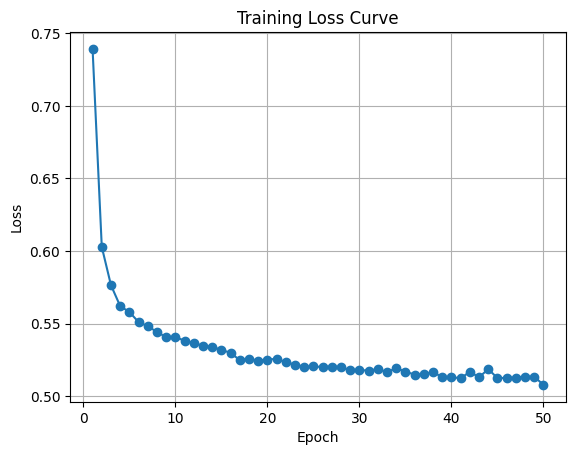

In [ ]:
plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()

In [ ]:
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(batch_y.numpy())

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")



Accuracy: 0.8589


In [ ]:
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[5013    0   78    6   16    7   17    3   11  179]
 [  28    1    3    2    7   10 5220    9   13   30]
 [   4    0 4983    0    0    0    2    0    0   63]
 [  66    2   22 3971   65   60   13    6   24  174]
 [  82    0    6   32 4641    1    8    8   11   48]
 [  26    0   21    3    3 4836   11   28    2   65]
 [  12    1    1    3    1   16 5318   13    1   28]
 [  18    1    7    1   16   18   13 4711   55   74]
 [  23    0   29    0   16   26   12   18 4615   46]
 [ 106    0   57   12   10   46   14   39   22 6026]]


In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=languages))

Classification Report:
              precision    recall  f1-score   support

     Bengali       0.93      0.94      0.94      5330
    Gujarati       0.20      0.00      0.00      5323
       Hindi       0.96      0.99      0.97      5052
     Kannada       0.99      0.90      0.94      4403
   Malayalam       0.97      0.96      0.97      4837
     Marathi       0.96      0.97      0.97      4995
     Punjabi       0.50      0.99      0.66      5394
       Tamil       0.97      0.96      0.97      4914
      Telugu       0.97      0.96      0.97      4785
        Urdu       0.89      0.95      0.92      6332

    accuracy                           0.86     51365
   macro avg       0.84      0.86      0.83     51365
weighted avg       0.83      0.86      0.82     51365



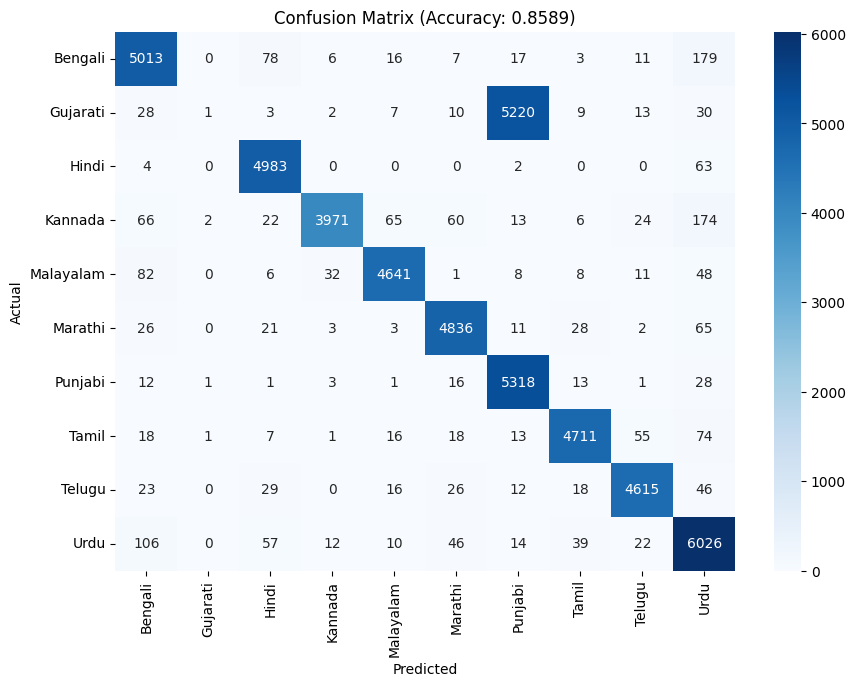

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=languages, yticklabels=languages)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.4f})')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


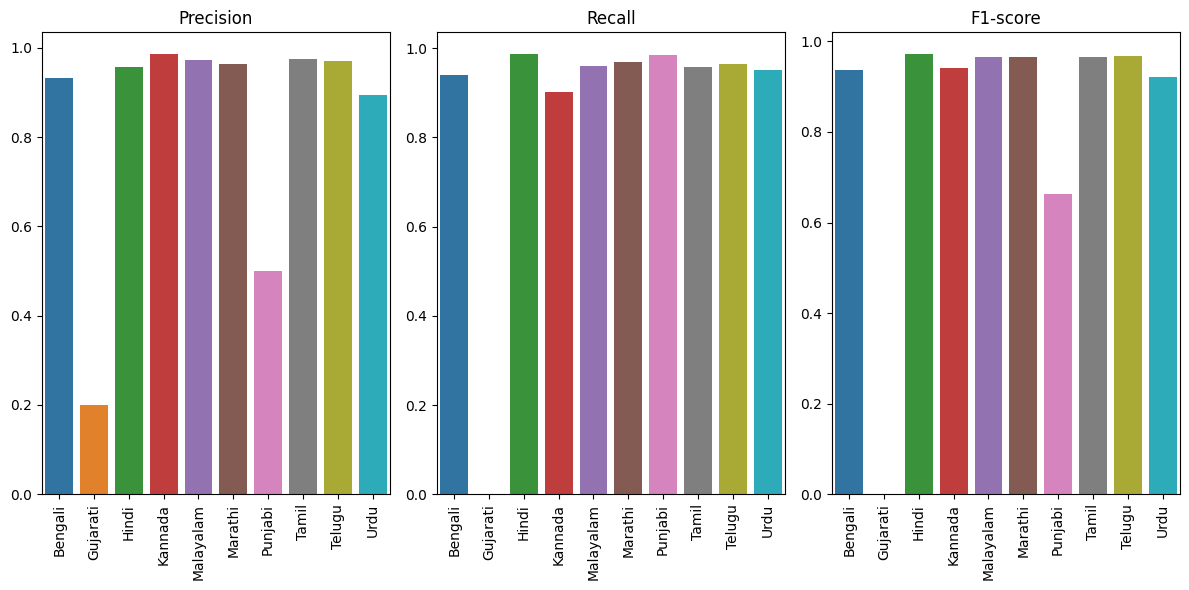

In [ ]:
report = classification_report(y_true, y_pred, target_names=languages, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
report_df = {metric: [report[label][metric] for label in languages] for metric in metrics}

plt.figure(figsize=(12, 6))
for idx, metric in enumerate(metrics):
    plt.subplot(1, 3, idx + 1)
    sns.barplot(x=languages, y=report_df[metric])
    plt.xticks(rotation=90)
    plt.title(metric.capitalize())

plt.tight_layout()
plt.show()

In [ ]:
sample_indices = np.random.choice(len(X_test_tensor), 5, replace=False)
sample_inputs = X_test_tensor[sample_indices].to(device)
sample_outputs = model(sample_inputs)
_, sample_preds = torch.max(sample_outputs, 1)

In [ ]:
num_samples = 5
random_indices = random.sample(range(len(y_test)), num_samples)

print("\nSample Predictions:")
for i, idx in enumerate(random_indices):
    predicted_lang = languages[y_pred[idx]]
    actual_lang = languages[y_test[idx]]

    lang_folder = os.path.join(DATASET_PATH, languages[y_test[idx]])
    audio_files = [f for f in os.listdir(lang_folder) if f.endswith(".mp3")]

    if audio_files:
        random_audio_file = random.choice(audio_files)
        audio_path = os.path.join(lang_folder, random_audio_file)

        print(f"Test Sample {i+1}: Predicted - {predicted_lang}, Actual - {actual_lang}")
        display(Audio(audio_path))
    else:
        print(f"Test Sample {i+1}: No audio file found for {languages[y_test[idx]]}")
    print()



Sample Predictions:
Test Sample 1: Predicted - Urdu, Actual - Urdu



Test Sample 2: Predicted - Malayalam, Actual - Malayalam



Test Sample 3: Predicted - Urdu, Actual - Urdu



Test Sample 4: Predicted - Malayalam, Actual - Malayalam



Test Sample 5: Predicted - Punjabi, Actual - Gujarati
